# UMAP + KMeans

In [1]:
import pandas as pd
import numpy as np

import umap.umap_ as umap

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import seaborn as sns
import matplotlib.pyplot as plt

random_seed = 2022
import warnings
warnings.filterwarnings("ignore")

In [2]:
def optimalK(data_type,data, algorithm1, algorithm2, title, random_state=2022, maxClusters=10):
    """
    Calculates optimal K using silhouette score
    Params:
        data_type: df, dissim
        data: ndarry of shape (n_samples, n_features)
        algorithm1: kmeans, kmedoids, or hierarchical
        algorithm2: kmeans, kmedoids, or hierarchical
        title: the title for the resulting figure
        maxClusters: Maximum number of clusters to test for
    Returns: (silh, optimalK)
    """
    silh = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'algorithm':[], 'clusterCount':[], 'silhouette':[]})
    for algorithm in [algorithm1, algorithm2]:
        for index, k in enumerate(range(2, maxClusters)):

            if algorithm == 'kmeans':
                model = KMeans(k, random_state=random_state)
                model.fit(data)
            if algorithm == 'hierarchical':
                model = AgglomerativeClustering(n_clusters=k,linkage = 'ward')
                model.fit(data)

            cluster_labels = model.fit_predict(data)
            silhouette_avg = silhouette_score(data, cluster_labels)
            
            resultsdf = resultsdf.append({'algorithm':algorithm, 'clusterCount':k, 
                                          'silhouette':silhouette_avg}, ignore_index=True)
    
    algorithm1_df = resultsdf[resultsdf['algorithm']==algorithm1]
    algorithm2_df = resultsdf[resultsdf['algorithm']==algorithm2]
    
    # Plot the silhouette scores for each algorithm
    plt.figure(figsize=(7,4))
    plt.xlim(1,maxClusters)
    sns.lineplot(data=resultsdf, x="clusterCount", y="silhouette", hue="algorithm")
    # Indicate the best k for each algorithm
    plt.scatter(algorithm1_df.loc[algorithm1_df['silhouette'].idxmax(),'clusterCount'], 
                algorithm1_df['silhouette'].max())
    plt.scatter(algorithm2_df.loc[algorithm2_df['silhouette'].idxmax(),'clusterCount'], 
                algorithm2_df['silhouette'].max())
    plt.xlabel('Cluster Count')
    plt.ylabel('Silhouette Value')
    plt.title(title)
    return (plt)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

def create_cluster_models(data_type, data, methods, ks, keep_orig=False):
    if data_type == 'df':
        if keep_orig == True:
            clust_results = data.loc[:]
        else:
            clust_results = pd.DataFrame(index=data.index)

        for k in ks:
            for m in methods:
                if m == "KMeans":
                    # KMeans clustering
                    fit_cluster = KMeans(n_clusters=k, random_state=random_seed).fit(data)
                    clust_results['cl_k'+str(k)] = fit_cluster.labels_

                elif m == "Hierarchical":
                    # Hierarchical clustering
                    fit_cluster = AgglomerativeClustering(n_clusters=k,linkage = 'ward').fit(data)
                    clust_results['cl_h'+str(k)] = fit_cluster.labels_

    return clust_results

In [3]:
def optimalK_grouped(data_type,data, algorithm1, algorithm2, title, random_state=2022, maxClusters=10):
    silh = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'algorithm':[], 'clusterCount':[], 'silhouette':[]})
    for algorithm in [algorithm1, algorithm2]:
        for index, k in enumerate(range(2, maxClusters)):
            
            if algorithm == 'kmeans':
                model = KMeans(k, random_state=random_state)
                model.fit(data)
            if algorithm == 'hierarchical':
                model = AgglomerativeClustering(n_clusters=k,linkage = 'ward')
                model.fit(data)

            cluster_labels = model.fit_predict(data)
            silhouette_avg = silhouette_score(data, cluster_labels)                               
            
            resultsdf = resultsdf.append({'algorithm':algorithm, 'clusterCount':k, 
                                          'silhouette':silhouette_avg}, ignore_index=True)
    
    return (resultsdf)


def neigh_dist(dissim):
    """UMAP"""
    neighbors = [3,4,5,6]
    dists = [0.001, 0.01, 0.1]

    umaps_results = pd.DataFrame(columns=['neighbor','distance','Dim1','Dim2'])
    for n in neighbors:
        for d in dists:
            temp_umap = umap.UMAP(n_neighbors=n, min_dist=d, n_components=2,
                                  random_state=random_seed,metric='precomputed').fit_transform(dissim)
            temp_umap = pd.DataFrame(temp_umap, columns=['Dim1','Dim2'])
            temp_umap['neighbor'] = n
            temp_umap['distance'] = d
            umaps_results = umaps_results.append(temp_umap, sort=True,ignore_index=True)
            
    # Create dataframe
    optimal_k_umap = pd.DataFrame()

    for dist in [0.001, 0.01, 0.1]:
        for ngbr in [3,4,5,6]:
            df_subset = umaps_results[(umaps_results['distance']==dist) & (umaps_results['neighbor']==ngbr)].iloc[:,:2]
            temp_df = optimalK_grouped(data_type='df',data=df_subset, algorithm1='kmeans', algorithm2='hierarchical', 
                                       random_state=random_seed, title="test")
            temp_df['distance'] = dist
            temp_df['neighbor'] = ngbr

            optimal_k_umap = optimal_k_umap.append(temp_df, ignore_index=True)


    optimal_k_umap = optimal_k_umap.reset_index(drop=True)
    optimal_k_umap_hierarchical = optimal_k_umap[optimal_k_umap['algorithm']=='hierarchical']
    optimal_k_umap_kmeans = optimal_k_umap[optimal_k_umap['algorithm']=='kmeans']
    
    # Plot
    f,axes = plt.subplots(2,1,figsize=(5,10))
    
    #Hierarchical clustering
    sns.lineplot(data=optimal_k_umap_hierarchical, x="clusterCount", y="silhouette", hue="distance",
                style="neighbor", palette='colorblind',ax=axes[0])
    axes[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    axes[0].set_title("Optimal Distance and Neighbor for " + " Hierarchical Clustering", fontsize=8)
    axes[0].scatter(optimal_k_umap_hierarchical.loc[optimal_k_umap_hierarchical['silhouette'].idxmax(),'clusterCount'],
                   optimal_k_umap_hierarchical['silhouette'].max(),c='red')
    h_dist = optimal_k_umap_hierarchical.loc[optimal_k_umap_hierarchical['silhouette'].idxmax(),'distance']
    h_neigh = optimal_k_umap_hierarchical.loc[optimal_k_umap_hierarchical['silhouette'].idxmax(),'neighbor']
    
    #KMeans clustering
    sns.lineplot(data=optimal_k_umap_kmeans, x="clusterCount", y="silhouette", hue="neighbor",
             style="distance", palette='colorblind')
    plt.title("Optimal Distance and Neighbor for " + " KMeans Clustering", fontsize=8)
    plt.scatter(optimal_k_umap_kmeans.loc[optimal_k_umap_kmeans['silhouette'].idxmax(),'clusterCount'],
                    optimal_k_umap_kmeans['silhouette'].max(),c='red')
    k_dist = optimal_k_umap_kmeans.loc[optimal_k_umap_kmeans['silhouette'].idxmax(),'distance']
    k_neigh = optimal_k_umap_kmeans.loc[optimal_k_umap_kmeans['silhouette'].idxmax(),'neighbor']
    
    #result_dict = {'hierarchical':optimal_k_umap_hierarchical,'kmeans':optimal_k_umap_kmeans,
    #               'h_parameter':[h_dist,h_neigh],'k_parameter':[k_dist,k_neigh]}
    result_dict = {'h_parameter':[h_dist,h_neigh],'k_parameter':[k_dist,k_neigh]}
    return(result_dict)

{'h_parameter': [0.1, 3], 'k_parameter': [0.1, 3]}

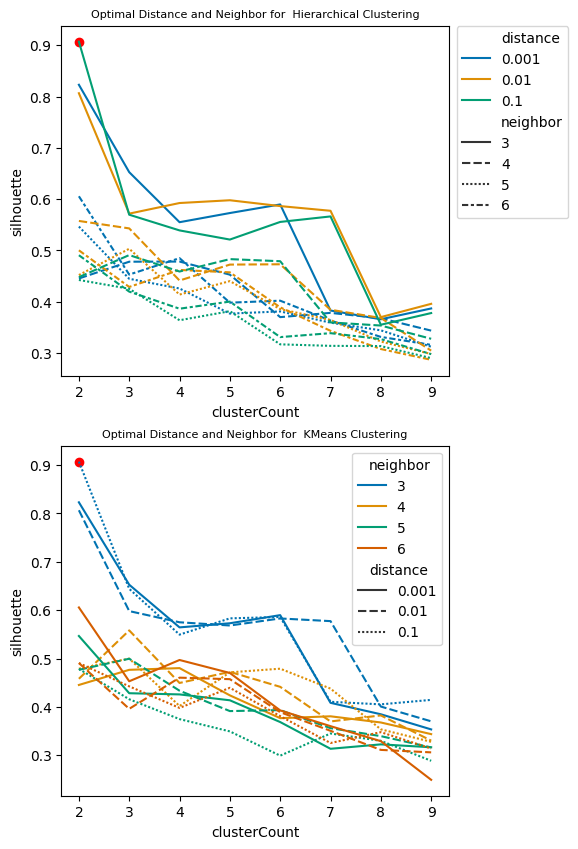

In [4]:
raw = pd.read_csv('../RSA_Regression/output_data/models_rdm/full_feature/raw33d_dissim_dist.csv',
                  index_col=0,encoding = "UTF-8")
dissim = raw
neigh_dist(raw)

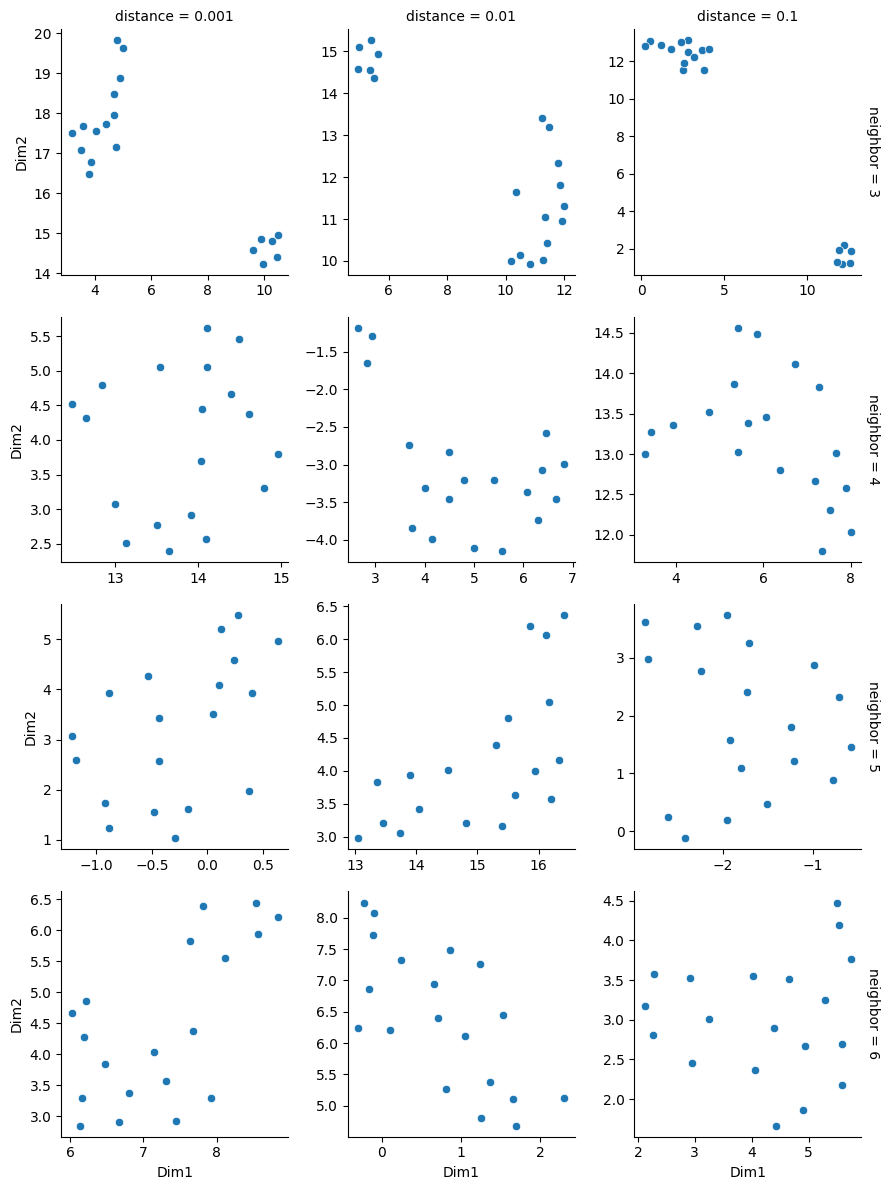

In [5]:
neighbors = [3,4,5,6]
dists = [0.001, 0.01, 0.1]

umaps_results = pd.DataFrame(columns=['neighbor','distance','Dim1','Dim2'])
for n in neighbors:
    for d in dists:
        temp_umap = umap.UMAP(n_neighbors=n, min_dist=d, n_components=2,
                              metric = 'precomputed',
                              random_state=2022).fit_transform(dissim)
        temp_umap = pd.DataFrame(temp_umap, columns=['Dim1','Dim2'])
        temp_umap['neighbor'] = n
        temp_umap['distance'] = d
        umaps_results = umaps_results.append(temp_umap, sort=True, 
                                             ignore_index=True)
        
g = sns.FacetGrid(umaps_results, row='neighbor', col='distance',
                  margin_titles=True, sharex=False, sharey=False)
g.map(sns.scatterplot, 'Dim1', 'Dim2')

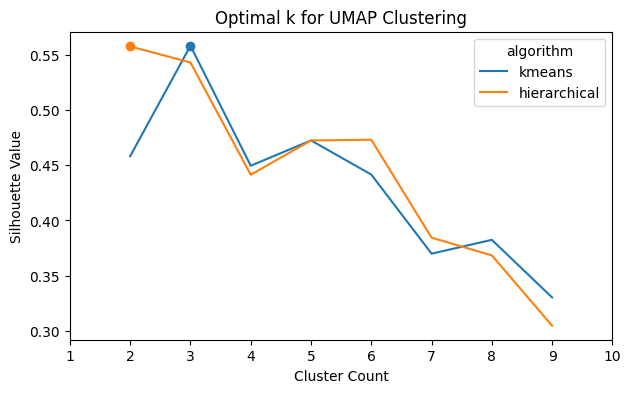

In [7]:
umap_final = umap.UMAP(n_neighbors=4, min_dist=0.01, n_components=2,
                    random_state=random_seed,metric='precomputed').fit_transform(dissim)
umap_final = pd.DataFrame(umap_final, columns=['Dim1','Dim2'],index = dissim.index)

optimalK(data_type='df',data=umap_final, algorithm1='kmeans', algorithm2='hierarchical', 
         random_state=2022, title="Optimal k for UMAP Clustering")

umap_results = create_cluster_models(data_type = "df",data = umap_final,
                                       methods=['KMeans', 'Hierarchical'],ks=[2,3,4,5,6],keep_orig=True)
umap_results.to_csv('output_data/clustering_19regions/raw33d_4_0.01.csv')

# Plot results

In [2]:
library(tidyverse)
library(reshape)

library(ggplot2)
library(ggrepel)
library(ggdendro) #get the details
library(dendextend) #change the plot
library(ape)

In [3]:
plot_results = function(umap_results,method_num){
    options(repr.plot.width=5,repr.plot.height=5)
    ggplot(umap_results,aes(x=Dim1,y=Dim2,color=factor(.data[[method_num]]))) + 
    geom_point(size = 3) + 
    geom_text_repel(aes(label = rownames(umap_results)),size = 6,
                   max.overlaps = getOption("ggrepel.max.overlaps", default = 20))+
    #ggtitle(strsplit(output_file,'.csv')[[1]][1])+
    theme_classic()+
    theme(plot.title = element_text(size = 30, face = "bold"),
         legend.position = 'none')
}

[1] "Hierarchical:"


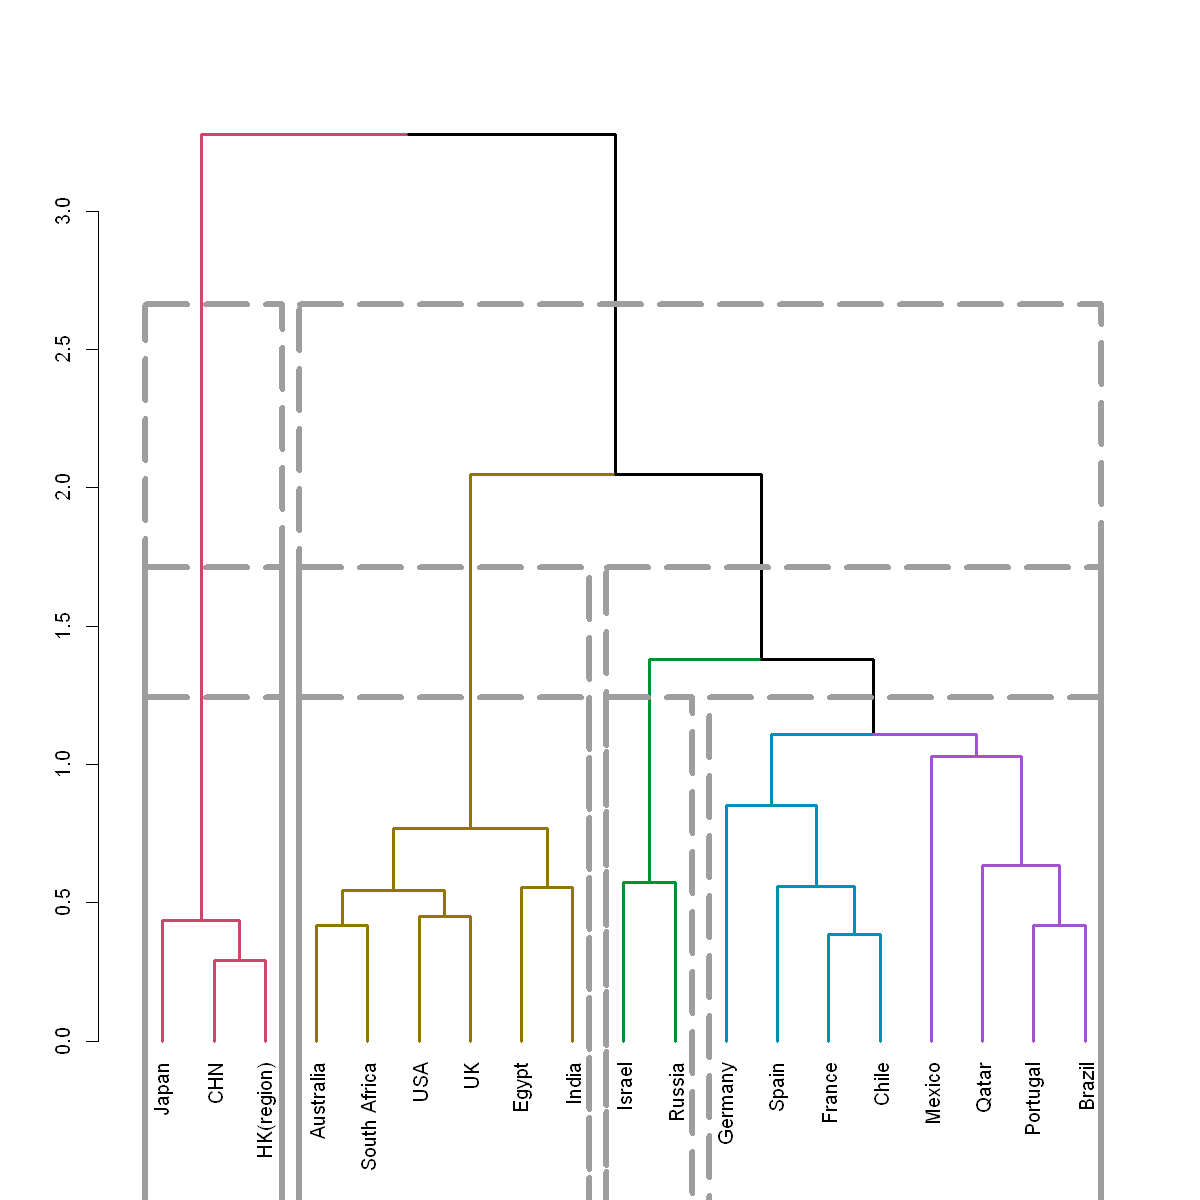

In [7]:
raw_results=read.csv('output_data/clustering_19regions/raw33d_4_0.01.csv',row.names=1)
# KMeans
# print('KMeans:')
# plot_results(raw_results,'cl_k2')
# plot_results(raw_results,'cl_k3')
# plot_results(raw_results,'cl_k4')
# plot_results(raw_results,'cl_k5')

print('Hierarchical:')
# Hierarchical
options(repr.plot.width=10,repr.plot.height=10)
dend = dist(raw_results[c('Dim1','Dim2')],method='euclidean') %>% 
    as.dist() %>%
    hclust(method = "average") %>%
    as.dendrogram() %>%    
    set("labels_cex", 1) %>% 
    set("branches_lwd", 3) %>%
    set("branches_k_color",k=5)
plot(dend)
dend %>% rect.dendrogram(k=2, border = 8, lty = 5, lwd = 5)
dend %>% rect.dendrogram(k=3, border = 8, lty = 5, lwd = 5)
dend %>% rect.dendrogram(k=4, border = 8, lty = 5, lwd = 5)
#dend %>% rect.dendrogram(k=5, border = 8, lty = 5, lwd = 5)
#dend %>% rect.dendrogram(k=6, border = 8, lty = 5, lwd = 5)

png 
  2

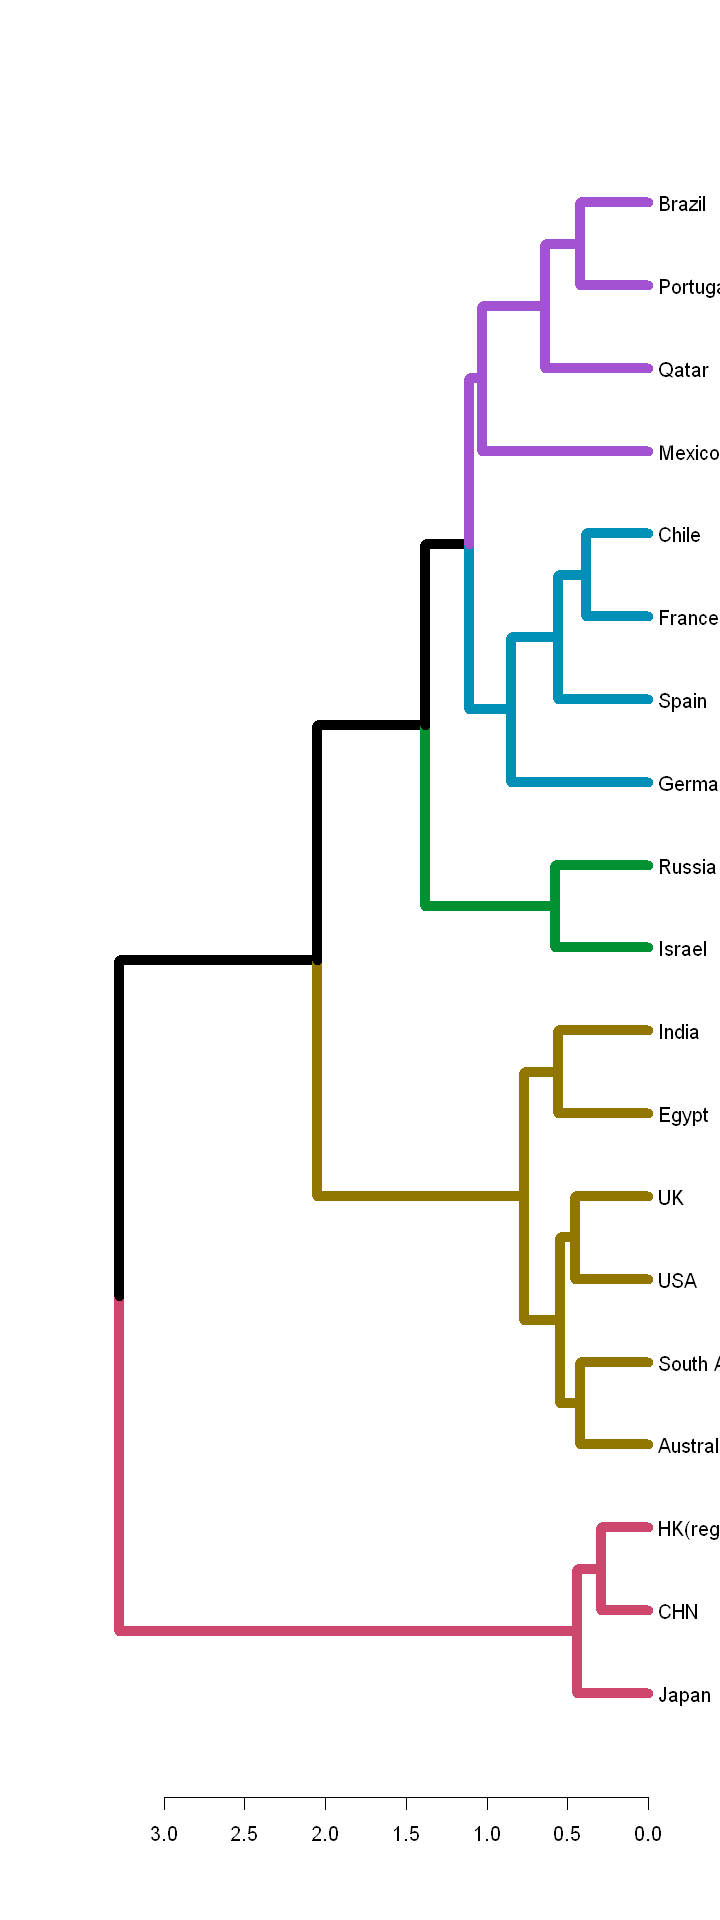

In [9]:
options(repr.plot.width=6,repr.plot.height=16)
dend = dist(raw_results[c('Dim1','Dim2')],method='euclidean') %>% 
    as.dist() %>%
    hclust(method = "average") %>%
    as.dendrogram() %>%    
    set("labels_cex", 1) %>% 
    set("branches_lwd", 8) %>%
    set("branches_k_color",k=5)
plot(dend,horiz = TRUE)

######################################################
png("../output_graph/Clustering19regions.png", bg="transparent",
    family = 'sans',units='in',width=6,height=16,res=300)
dend = dist(raw_results[c('Dim1','Dim2')],method='euclidean') %>% 
    as.dist() %>%
    hclust(method = "average") %>%
    as.dendrogram() %>%    
    set("labels_cex", 1) %>% 
    set("branches_lwd", 8) %>%
    set("branches_k_color",k=5)
plot(dend,horiz = TRUE,leaflab = "none")
dev.off()